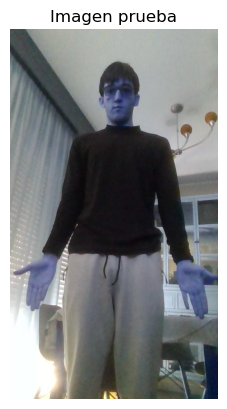

La pose clasificada es: tadasana


In [ ]:
import os
import cv2
import mediapipe as mp
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

# Inicializar MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)

# Inicializar k (cantidad de vecinos)
k = 5

# Ruta del CSV con datos de entrenamiento
csv_path = "knn.csv"

# Cargar dataset en un DataFrame
df = pd.read_csv(csv_path)

# Ruta de la imagen a clasificar
pose_path = "tadasana_prueba.png"

imagen = cv2.imread(pose_path, cv2.COLOR_BGR2RGB)
plt.imshow(imagen,cmap='gray')
plt.title("Imagen prueba")
plt.axis("off")
plt.show()


# Leer la imagen y procesarla con MediaPipe
image = cv2.imread(pose_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
results = pose.process(image_rgb)

if not results.pose_landmarks:
    print("Landmarks nulos")
    exit()

# Obtener coordenadas de los landmarks
landmarks = {lm_idx: (lm.x, lm.y, lm.z) for lm_idx, lm in enumerate(results.pose_landmarks.landmark)}

# Lista para almacenar los vectores de la imagen a clasificar
image_vectors = {}

# Obtener los nombres de los puntos de referencia
landmark_names = mp_pose.PoseLandmark

# Calcular los vectores de la imagen a clasificar
for connection in mp_pose.POSE_CONNECTIONS:
    start_idx, end_idx = connection

    # Obtener los nombres de los puntos de conexión
    start_name = landmark_names(start_idx).name
    end_name = landmark_names(end_idx).name

    # Crear nombre del vector
    vector_name = f"{start_name}_{end_name}"

    # Obtener las coordenadas
    x1, y1, z1 = landmarks[start_idx]
    x2, y2, z2 = landmarks[end_idx]

    # Calcular el vector
    vec_x = x2 - x1
    vec_y = y2 - y1
    vec_z = z2 - z1

    # Guardar el vector
    image_vectors[vector_name] = (vec_x, vec_y, vec_z)

# Función para calcular la distancia basada en el coseno (con valor absoluto)
def cosine_distance(vec1, vec2):
    v1 = np.array(vec1)
    v2 = np.array(vec2)
    cos_sim = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2) + 1e-9)  
    return 1 - abs(cos_sim)  # Tomamos el valor absoluto del coseno

# Diccionario para sumar puntos a cada clasificación
classification_scores = Counter()

# Aplicar k-NN para cada vector individualmente
for vector_name, query_vector in image_vectors.items():
    # Filtrar dataset por el mismo "name"
    subset = df[df["name"] == vector_name]

    # Si no hay coincidencias en el dataset, continuar
    if subset.empty:
        continue

    # Lista de distancias
    distances = []

    # Comparar con cada fila del subset
    for _, row in subset.iterrows():
        dataset_vector = (row["x"], row["y"], row["z"])
        distance = cosine_distance(dataset_vector, query_vector)
        distances.append((distance, row["classification"]))

    # Ordenar por distancia y seleccionar los k más cercanos
    distances.sort(key=lambda x: x[0])
    k_nearest = distances[:k]

    # Sumar un punto por cada clasificación encontrada en los k vecinos más cercanos
    for _, classification in k_nearest:
        classification_scores[classification] += 1

# Determinar la clasificación con más puntos, lista de 1 elemento mas comun, y extraer el elemento y el primer valor del elemento
predicted_class = classification_scores.most_common(1)[0][0]

print(f"La pose clasificada es: {predicted_class}")
